### Algorithm:
1. Pre-processing
2. Gaussian Smoothing
3. Adaptive Thresholding
4. Morphological Opening (Noise Removal)
5. Largest Connected Component
6. Mophological Closing (To intensify the Outer grid)
7. Hough Transform
8. Unwarping and division in blocks
9. Extraction of digits (LCC)
10. Digit Classification
11. Solving the sudoku (Backtracking)
12. Overlaying the solution

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv

from os.path import join

plt.rcParams['figure.figsize'] = [8, 8]
# fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

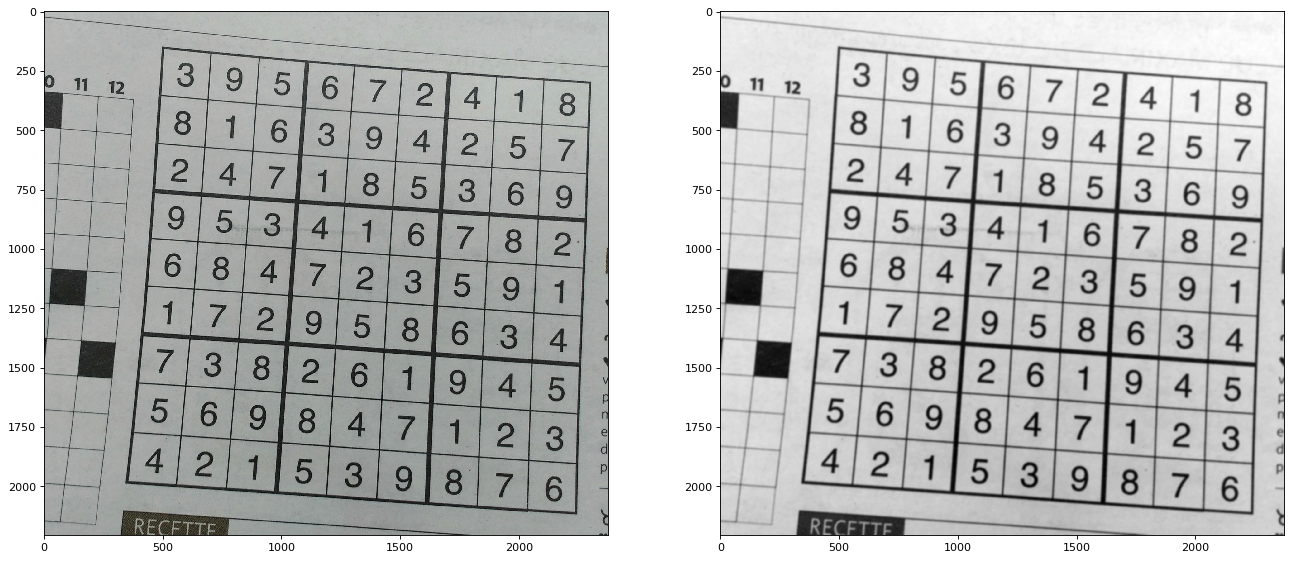

In [49]:
#Pre-processing
imgpath = "./test_imgs/";
img = cv.imread(join(imgpath, "sudoku1.jpg"));

#Resize image
# img = cv.resize(img, (0,0), fx=0.1, fy=0.1) 
rows,cols,ch = img.shape

#Convert to grayscale
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY);

#Smoothing to remove any extra noise
img_gray = cv.GaussianBlur(img_gray,(21,21),0)

fig=plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121); plt.imshow(img);
plt.subplot(122); plt.imshow(img_gray, 'gray')
plt.show()

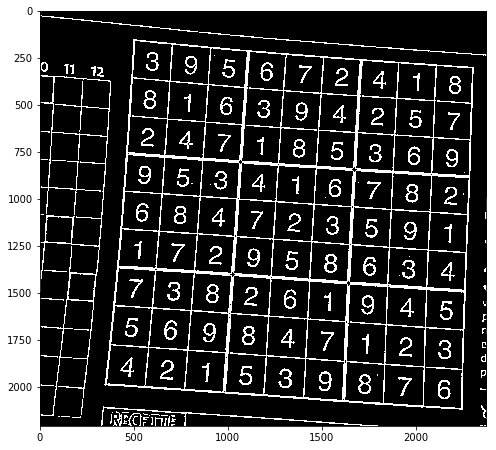

In [50]:
#Adaptive Thresholding
bw = cv.adaptiveThreshold(img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 21, 4);
bw = ~bw
plt.imshow(bw, 'gray')
plt.show()

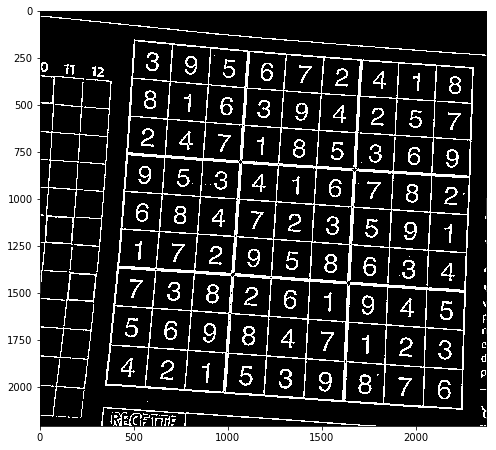

In [51]:
#Noise Removal (Morphological Opening)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2));
opened = cv.morphologyEx(bw, cv.MORPH_OPEN, kernel);
plt.imshow(opened, 'gray')
plt.show()

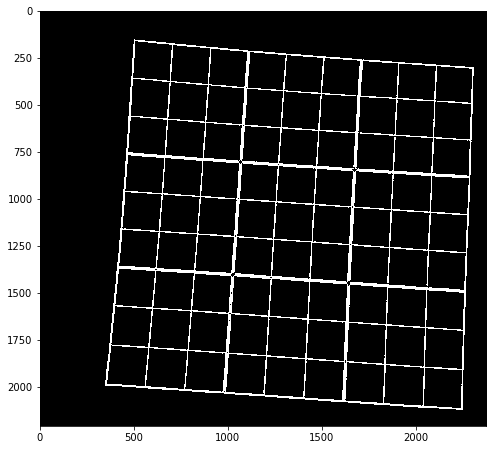

In [52]:
#Largest Connected Component
def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    plt.imshow(img2, 'gray')
    plt.show()
    return img2

outer_grid = undesired_objects(opened)

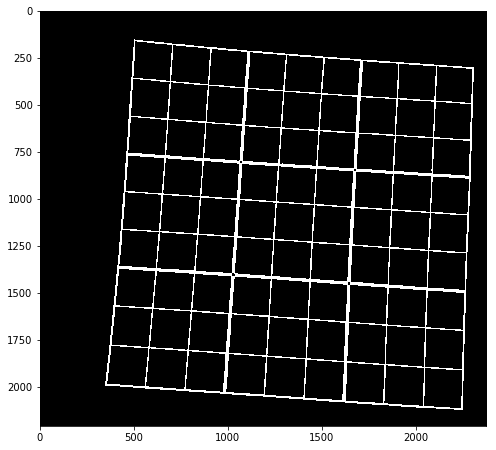

In [53]:
kernel = cv.getStructuringElement(cv.MORPH_RECT,(10,10));
closed_grid = cv.morphologyEx(outer_grid, cv.MORPH_CLOSE, kernel);
plt.imshow(closed_grid, 'gray')
plt.show()

In [37]:
#Hough Transform
print(closed_grid.shape)
# edges = cv2.Canny(gray,50,150,apertureSize = 3)
# closed_grid.dtype = np.float32

lines = cv.HoughLines(closed_grid, 1, np.pi/180, 200)
for rho, theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv.line(closed_grid,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow(closed_grid, 'gray')
plt.show()

(221, 237)


error: /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/hough.cpp:86: error: (-215) img.type() == CV_8UC1 in function HoughLinesStandard


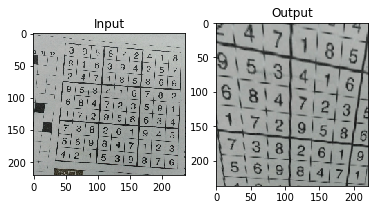

In [22]:
#Unwarping the image

pts2 = np.float32([[0,0], [rows,0], [0,cols], [rows,cols]])

geo_matrix = cv.getPerspectiveTransform(pts1,pts2)

dst = cv.warpPerspective(img, geo_matrix, (rows,cols))

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [ ]:
#Divide it into blocks


In [23]:
#Train NN on MNIST
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
60000/60000 [==============================] - 13s 223us/step - loss: 0.2020 - acc: 0.9400
Epoch 2/5
60000/60000 [==============================] - 13s 213us/step - loss: 0.0810 - acc: 0.9758
Epoch 3/5
60000/60000 [==============================] - 17s 278us/step - loss: 0.0534 - acc: 0.9835
Epoch 4/5
60000/60000 [==============================] - 20s 332us/step - loss: 0.0381 - acc: 0.9877
Epoch 5/5
10000/10000 [==============================] - 1s 62us/step


[0.06851553161724006, 0.979]

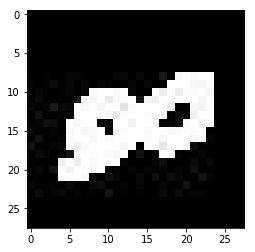

0


In [76]:
#Testing the model
test_digit = cv.imread(join(imgpath, "testdig8.jpg"))
test_digit = cv.cvtColor(test_digit, cv.COLOR_BGR2GRAY)/255.0
plt.imshow(test_digit, 'gray')
plt.show()
predictions = model.predict(np.array([test_digit]))
print(np.argmax(predictions[0]))

In [ ]:
#Extracting the digits


In [ ]:
#Solving the sudoku
def solve_sudoku():
    
    return solution

In [ ]:
#Overlaying
